In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from model import get_model
from dataset import load_data, pdgTokens, tokenize_dict

# The dataset

Download url: https://cernbox.cern.ch/index.php/s/9Z1XjrS9ofuyA33

The dataset contains 4 blocks of 100k events (all shuffled and balanced 50:50). The following uses the first block for training and the last block for testing. You can adjust this, e.g. to use the first 3 blocks for training set `train_stop=3`.

In [2]:
x_train, x_test, y_train, y_test, feature_names = load_data(
    "erum_data_classifier_comparison.npz",
    train_start=0, train_stop=1, test_start=3, test_stop=4
)

The dataset contains 3 arrays:
 * `x_feature` : particle features
 * `x_pdg` : pdg ids of each particle
 * `x_adjacency` : indices of mother particles. This array, if one-hot-encoded, gives the adjacency matrix

In [3]:
x_train.keys()

dict_keys(['x_feature', 'x_pdg', 'x_adjacency'])

The particle lists are padded to a maximum number of 100 particles per event. Missing values are set to 0, except for the `x_adjacency` array, where they are set to -1.

In [4]:
[x.shape for x in x_train.values()]

[(100000, 100, 8), (100000, 100), (100000, 100)]

No scaling is applied for the features, since they are already in a range around 0. However, one could optimize this.

In [5]:
feature_names

['prodTime', 'energy', 'x', 'y', 'z', 'px', 'py', 'pz']

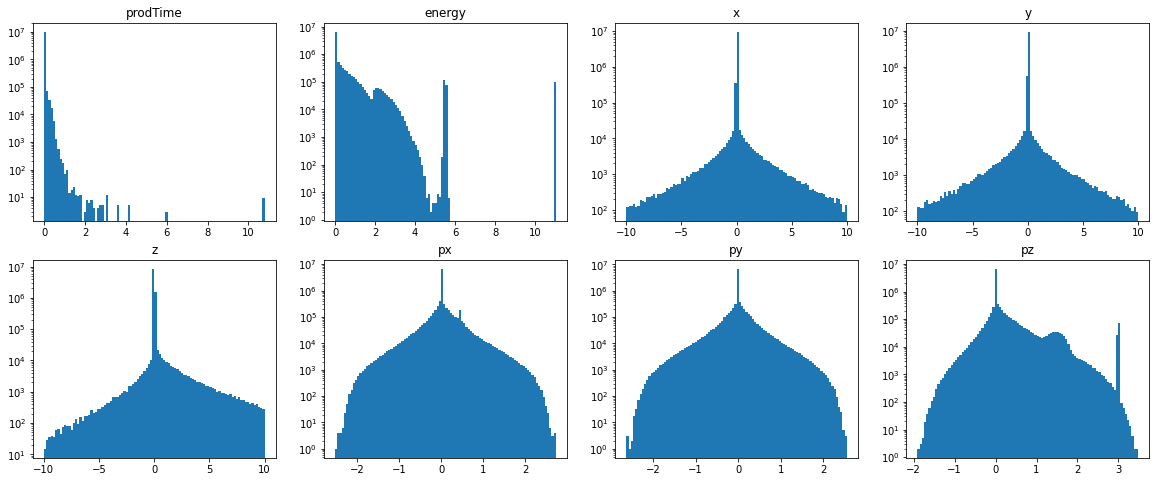

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
for i, (name, ax) in enumerate(zip(feature_names, np.array(axs).ravel())):
    ax.hist(x_train["x_feature"][:,:,i].ravel(), bins=100)
    ax.set_title(name)
    ax.set_yscale("log")

The pdg ids are mapped to numbers in a continuous range, since we want to feed them through an embedding layer. The `tokenize_dict` can be used to reverse the mapping.

In [7]:
reverse_tokenize_dict = {v : k for k, v in tokenize_dict.items()}

@np.vectorize
def revert_pdg_tokens(pdg_token):
    return reverse_tokenize_dict[pdg_token]

In [8]:
revert_pdg_tokens(x_train["x_pdg"][0])

array([300553,   -511,    511,    415,     13,    -14,   -213,    211,
         -213,    213,    311,    411,    111,   -211,    111,   -211,
          111,    211,    111,    130,    310,    211,    111,     22,
           22,     22,     22,     22,     22,     22,     22,    211,
         -211,     22,     22,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0])

# The reference model

The reference model consists of 2 Blocks, 1 Block is a per-particle transformation (including a few simple Graph convolution layers) and then after summing the latent space for all particles a Block of Dense layers that perform an event-level transformation. Have a look at `model.py`

The mother indices are converted to adjacency matrices on-the-fly.

In [9]:
model = get_model(
    num_nodes=x_train["x_adjacency"].shape[1],
    num_features=x_train["x_feature"].shape[2],
    num_pdg=len(pdgTokens),
)

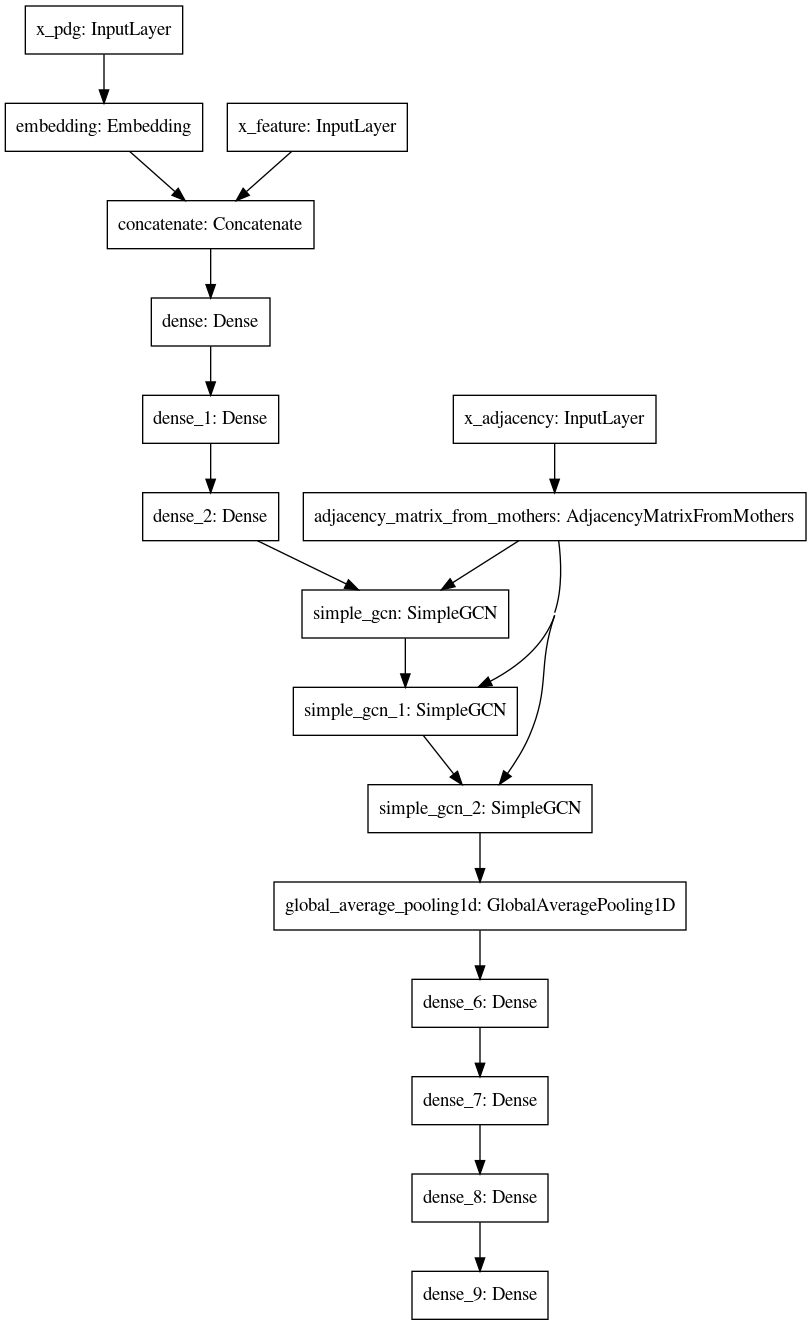

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_pdg (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 8)       4328        x_pdg[0][0]                      
__________________________________________________________________________________________________
x_feature (InputLayer)          [(None, 100, 8)]     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 100, 16)      0           embedding[0][0]                  
                                                                 x_feature[0][0]              

In [12]:
model.compile(optimizer="adam", loss="binary_crossentropy")

In [13]:
history = model.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=128,
    validation_split=0.25,
    epochs=25,
)

Epoch 1/25
586/586 [==============================] - 7s 12ms/step - loss: 0.5304 - val_loss: 0.4672
Epoch 2/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4697 - val_loss: 0.4722
Epoch 3/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4567 - val_loss: 0.4419
Epoch 4/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4487 - val_loss: 0.4367
Epoch 5/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4426 - val_loss: 0.4367
Epoch 6/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4371 - val_loss: 0.4250
Epoch 7/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4324 - val_loss: 0.4220
Epoch 8/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4286 - val_loss: 0.4255
Epoch 9/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4262 - val_loss: 0.4404
Epoch 10/25
586/586 [==============================] - 7s 12ms/step - loss: 0.4208 - val_lo

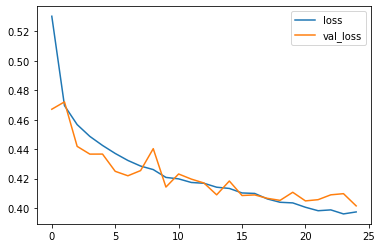

In [14]:
for k in history.history:
    plt.plot(history.history[k], label=k)
plt.legend()

In [15]:
scores = model.predict(x_test, batch_size=1024).ravel()

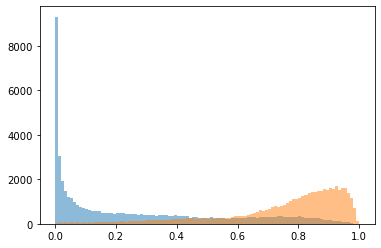

In [16]:
opts = dict(bins=100, range=(0, 1), alpha=0.5)
plt.hist(scores[y_test==0], **opts)
plt.hist(scores[y_test==1], **opts);

In [17]:
from sklearn.metrics import roc_curve, auc

In [18]:
fpr, tpr, thr = roc_curve(y_test, scores)

0.8944641640633897

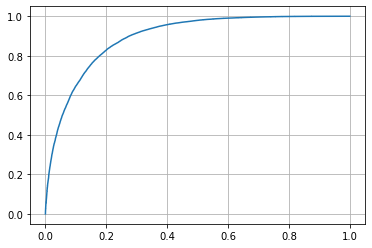

In [19]:
plt.plot(fpr, tpr)
plt.grid()
auc(fpr, tpr)